<a href="https://colab.research.google.com/github/MatSci495/Lectures/blob/main/WEIBULL_posted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Distribution Functions: **Context**

### 1.1 PDF and CDF

**Probability distribution functions (PDF)** are often used to describe variability in materials structure or behavior. More generally, a distribution assigns probabilities to outcomes of a random variable $X$.

**PDF $f(x)$:** relative likelihood of observing value $x$.


The cumulative distribution function (**CDF**) represents the probability that $X \le x$:

$$F(x) = \int_{-\infty}^x f(t)dt$$  


In reliability analysis, $F(x)$ represents the **probability of failure by stress or time $x$**, while $1 - F(x)$ represents **survival**.\
In statistical inference, $F(x)$ can represent the **probability of observing a value less than or equal to a test statistic**.

---

###  1.2 Dimensional Interpretation

- For a scalar variable (e.g., breakdown voltage), $f(x)$ describes a one-dimensional probability density.  
- For multivariate data (e.g., multiple failure modes), we can consider joint or conditional distributions.  

Dimensional reduction or transformation (like the Weibull linearization) often reveals simpler structure and allows direct parameter estimation.

---

### 1.3 Use in Hypothesis Testing

In hypothesis testing, distributions play two roles:
1. They describe **measurement uncertainty or natural variability** in the data.  
2. They provide **reference distributions** for test statistics—e.g., how likely it is to observe a deviation as large as we did if the null hypothesis were true.

Understanding PDFs and CDFs thus provides the mathematical foundation for:
- Evaluating *p-values*,
- Constructing *confidence intervals*,
- Comparing competing models.


# 2 · The Weibull Distribution

The **Weibull distribution** is widely used in materials science to describe the probability of *failure events*—from dielectric breakdown in thin films to fracture of ceramics and polymer fibers.\
It captures how the likelihood of failure grows with applied stress, electric field, or time.

* * *

## 2.1 Derivation of the Probability Density Function (PDF)

Suppose that a material fails when the first microscopic region (the *weakest link*) reaches its critical threshold.\
If the probability that a region *has not* failed by stress \(x\) is \(S(x)\) (the **survival function**), then

$$
S(x) = e^{-(x/\eta)^\beta},
$$

where  
- $\beta$ = **shape parameter** (dimensionless),  
- $\eta$ = **scale parameter** (same units as \(x\)).

<br>

The cumulative distribution function (CDF) for failure is

$$
F(x) = 1 - S(x) = 1 - e^{-(x/\eta)^\beta}.
$$

<br>

The probability density function (PDF) is the derivative of the CDF:

$$
f(x) = \frac{dF}{dx} = \frac{\beta}{\eta}\left(\frac{x}{\eta}\right)^{\beta - 1} e^{-(x/\eta)^\beta}.
$$

* * *

## 2.2 Physical Meaning in Materials Reliability

- **Shape parameter $\beta$:**  
  - $\beta < 1$: early failures dominate (infant mortality).  
  - $\beta = 1$: constant failure rate (random, memoryless process → exponential distribution).  
  - $\beta > 1$: failures increase with time or stress (wear-out behavior).
- **Scale parameter $\eta$:**  
  - Characteristic value at which 63.2% of samples have failed, $F(\eta) = 1 - e^{-1}$.  
  - Interpreted as the "typical" breakdown field, lifetime, or strength.

* * *

### 2.3 Examples in Materials Science

1. **Dielectric breakdown:**\
In self-assembled nanodielectrics or oxide films, each microscopic region may have a slightly different defect density.\
The sample fails when the first weak region reaches its limit.\
Weibull analysis quantifies uniformity—steeper slopes mean fewer weak spots.
2. **Mechanical failure:**\
In ceramics or glass fibers, crack initiation follows a weakest-link process.\
A high $\beta$ indicates consistent strength; a low $\beta$ indicates large variability due to flaws.

* * *

**Interpretation:**\
The Weibull function connects physical mechanisms (defects, damage accumulation) to probabilistic behavior.\
It is particularly useful when failure does **not** occur at a single deterministic value but follows a distribution shaped by microscopic variability.

## Plotting Weibull PDF and CDF

### Definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma

# Weibull utilities (shape=beta, scale=eta)
def weibull_pdf(x, beta, eta):
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x > 0 # Handle x > 0 first
    y[mask] = (beta/eta) * (x[mask]/eta)**(beta - 1) * np.exp(-(x[mask]/eta)**beta)

    # Handle x == 0 case
    zero_mask = x == 0
    if beta == 1:
        y[zero_mask] = 1.0/eta # Exponential distribution case
    elif beta > 1:
        y[zero_mask] = 0.0 # PDF is 0 at x=0 for beta > 1
    # If beta < 1, PDF is infinite at x=0, which we approximate as 0 for plotting purposes over a continuous domain.
    # The previous masking already sets y[zero_mask] to 0.0 for beta < 1.
    return y


def weibull_cdf(x, beta, eta):
    x = np.asarray(x)
    y = np.zeros_like(x, dtype=float)
    mask = x >= 0
    y[mask] = 1.0 - np.exp(-(x[mask]/eta)**beta)
    return y

def weibull_survival(x, beta, eta):
    return 1.0 - weibull_cdf(x, beta, eta)

def weibull_hazard(x, beta, eta):
    # h(x) = f(x) / S(x)
    f = weibull_pdf(x, beta, eta)
    S = weibull_survival(x, beta, eta)
    with np.errstate(divide="ignore", invalid="ignore"):
        h = np.where(S > 0, f / S, np.nan)
    return h

# Reasonable x-domain helper based on scale
def x_grid(eta, x_max_mult=3.0, n=800):
    xmax = x_max_mult * eta * (1 + 1.0/eta)  # a loose bump to ensure tail coverage
    return np.linspace(0, max(xmax, 6*eta), n)

### Single Distribution

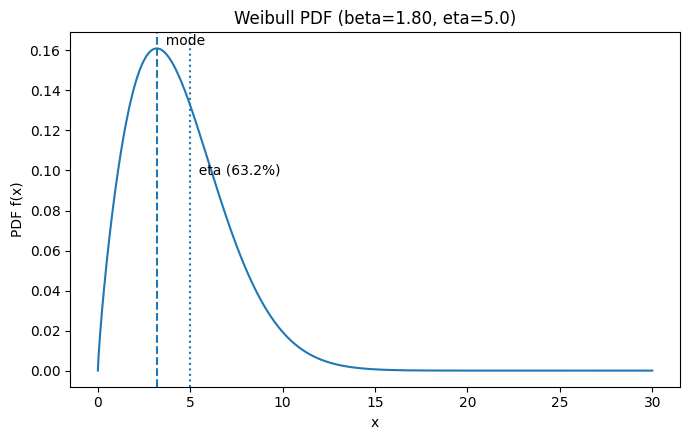

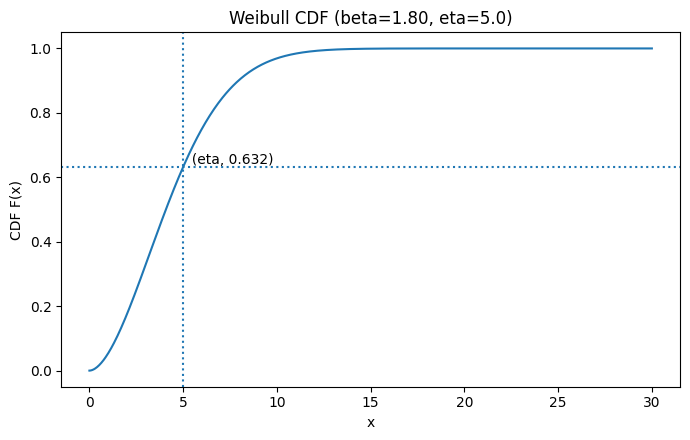

In [ ]:
# Parameters (adjust these to illustrate regimes)
beta = 1.8   # shape parameter
eta  = 5.0  # scale parameter (same units as x: e.g., breakdown voltage)

x = x_grid(eta)

# --- PDF ---
plt.figure(figsize=(7,4.5))
pdf = weibull_pdf(x, beta, eta)
plt.plot(x, pdf)
plt.xlabel("x")
plt.ylabel("PDF f(x)")
plt.title(f"Weibull PDF (beta={beta:.2f}, eta={eta:.1f})")

# Annotate mode (exists for beta > 1): x_mode = eta * ((beta-1)/beta)^(1/beta)
if beta > 1:
    x_mode = eta * ((beta - 1.0)/beta)**(1.0/beta)
    y_mode = weibull_pdf(x_mode, beta, eta)
    plt.axvline(x_mode, linestyle="--")
    plt.text(x_mode, y_mode, "  mode", va="bottom")

# Mark scale eta (63.2% quantile)
plt.axvline(eta, linestyle=":")
plt.text(eta, max(pdf)*0.6, "  eta (63.2%)", va="bottom")
plt.tight_layout()
plt.show()

# --- CDF ---
plt.figure(figsize=(7,4.5))
cdf = weibull_cdf(x, beta, eta)
plt.plot(x, cdf)
plt.xlabel("x")
plt.ylabel("CDF F(x)")
plt.title(f"Weibull CDF (beta={beta:.2f}, eta={eta:.1f})")

# Mark F(eta)=1-exp(-1) ~ 0.632
plt.axhline(1.0 - np.exp(-1.0), linestyle=":")
plt.axvline(eta, linestyle=":")
plt.text(eta, 1.0 - np.exp(-1.0), "  (eta, 0.632)", va="bottom")
plt.tight_layout()
plt.show()


### Families of Curves

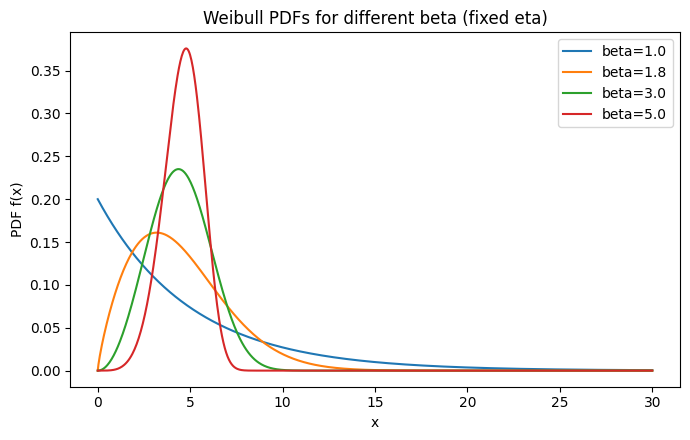

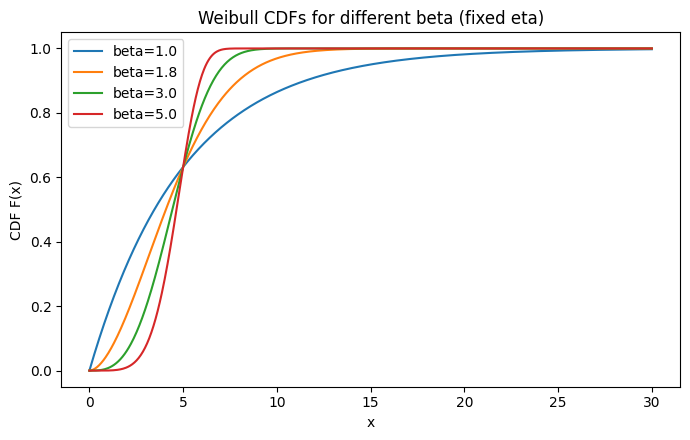

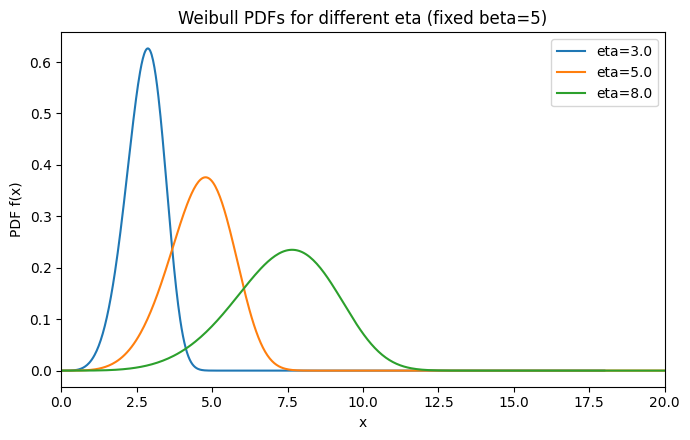

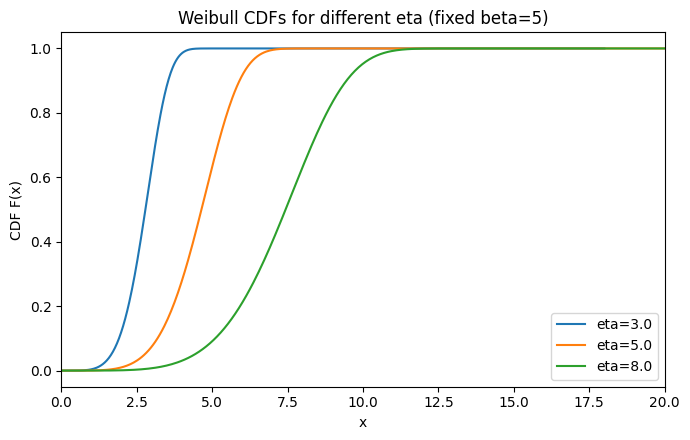

In [ ]:
eta = 5.0
betas = [1.0, 1.8, 3.0, 5.0]   # <1 (infant mortality), =1 (exp), >1 (wear-out)
x = x_grid(eta)

# PDF family by beta
plt.figure(figsize=(7,4.5))
for b in betas:
    plt.plot(x, weibull_pdf(x, b, eta), label=f"beta={b}")
plt.xlabel("x")
plt.ylabel("PDF f(x)")
plt.title("Weibull PDFs for different beta (fixed eta)")
plt.legend()
plt.tight_layout()
plt.show()

# CDF family by beta
plt.figure(figsize=(7,4.5))
for b in betas:
    plt.plot(x, weibull_cdf(x, b, eta), label=f"beta={b}")
plt.xlabel("x")
plt.ylabel("CDF F(x)")
plt.title("Weibull CDFs for different beta (fixed eta)")
plt.legend()
plt.tight_layout()
plt.show()

# Scale effect: vary eta at fixed beta
beta = 5
etas = [3.0, 5.0, 8.0]
plt.figure(figsize=(7,4.5))
for e in etas:
    xx = x_grid(e)
    plt.plot(xx, weibull_pdf(xx, beta, e), label=f"eta={e}")
plt.xlabel("x")
plt.ylabel("PDF f(x)")
plt.title(f"Weibull PDFs for different eta (fixed beta={beta})")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4.5))
for e in etas:
    xx = x_grid(e)
    plt.plot(xx, weibull_cdf(xx, beta, e), label=f"eta={e}")
plt.xlabel("x")
plt.ylabel("CDF F(x)")
plt.title(f"Weibull CDFs for different eta (fixed beta={beta})")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

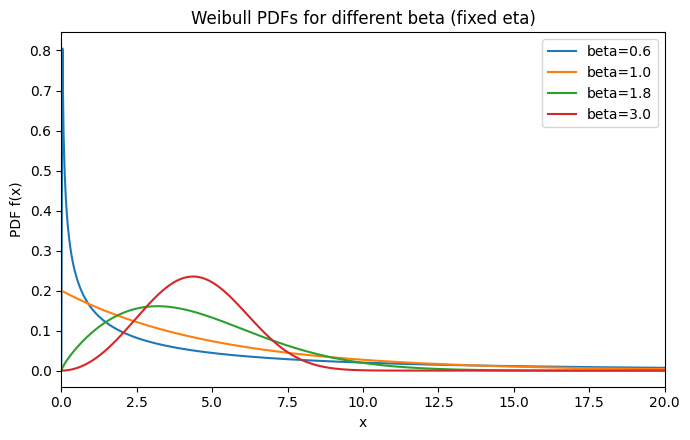

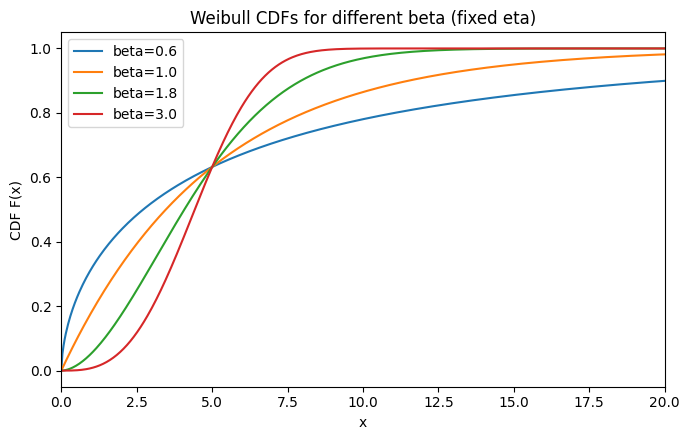

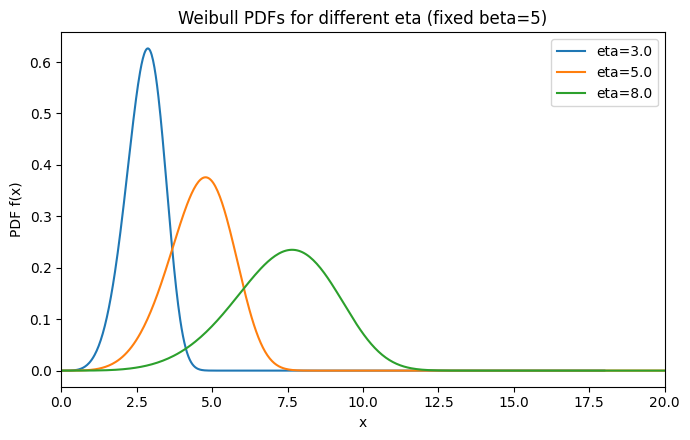

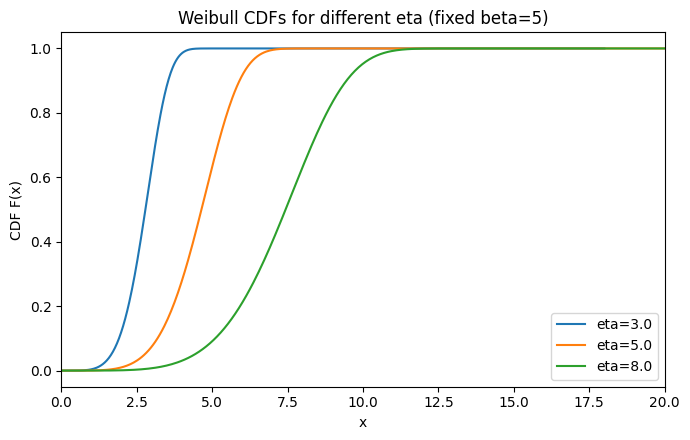

In [ ]:
eta = 5.0
betas = [0.6, 1.0, 1.8, 3.0]   # <1 (infant mortality), =1 (exp), >1 (wear-out)
x = x_grid(eta)

# PDF family by beta
plt.figure(figsize=(7,4.5))
for b in betas:
    plt.plot(x, weibull_pdf(x, b, eta), label=f"beta={b}")
plt.xlabel("x")
plt.ylabel("PDF f(x)")
plt.title("Weibull PDFs for different beta (fixed eta)")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

# CDF family by beta
plt.figure(figsize=(7,4.5))
for b in betas:
    plt.plot(x, weibull_cdf(x, b, eta), label=f"beta={b}")
plt.xlabel("x")
plt.ylabel("CDF F(x)")
plt.title("Weibull CDFs for different beta (fixed eta)")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

# Scale effect: vary eta at fixed beta
beta = 5
etas = [3.0, 5.0, 8.0]
plt.figure(figsize=(7,4.5))
for e in etas:
    xx = x_grid(e)
    plt.plot(xx, weibull_pdf(xx, beta, e), label=f"eta={e}")
plt.xlabel("x")
plt.ylabel("PDF f(x)")
plt.title(f"Weibull PDFs for different eta (fixed beta={beta})")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,4.5))
for e in etas:
    xx = x_grid(e)
    plt.plot(xx, weibull_cdf(xx, beta, e), label=f"eta={e}")
plt.xlabel("x")
plt.ylabel("CDF F(x)")
plt.title(f"Weibull CDFs for different eta (fixed beta={beta})")
plt.legend()
plt.xlim(0, 20) # Set x-axis limit
plt.tight_layout()
plt.show()

### Interactive Plot

In [ ]:
# Colab usually supports ipywidgets out of the box.
# If sliders do not render, run: !pip install ipywidgets and then restart the runtime.

import numpy as np
import matplotlib.pyplot as plt
try:
    from ipywidgets import interact, FloatSlider
except Exception as e:
    print("ipywidgets not available; skip this cell.")

def show_weibull(beta=1.8, eta=50.0):
    x = x_grid(eta)
    plt.figure(figsize=(7,4.5))
    plt.plot(x, weibull_pdf(x, beta, eta))
    plt.xlabel("x")
    plt.ylabel("PDF f(x)")
    plt.title(f"PDF: beta={beta:.2f}, eta={eta:.1f}")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(7,4.5))
    plt.plot(x, weibull_cdf(x, beta, eta))
    plt.xlabel("x")
    plt.ylabel("CDF F(x)")
    plt.title(f"CDF: beta={beta:.2f}, eta={eta:.1f}")
    plt.tight_layout()
    plt.show()

try:
    interact(
        show_weibull,
        beta=FloatSlider(value=1.8, min=0.3, max=5.0, step=0.1),
        eta=FloatSlider(value=50.0, min=5.0, max=150.0, step=1.0),
    )
except:
    pass


interactive(children=(FloatSlider(value=1.8, description='beta', max=5.0, min=0.3), FloatSlider(value=50.0, de…

### Empirical vs Theory

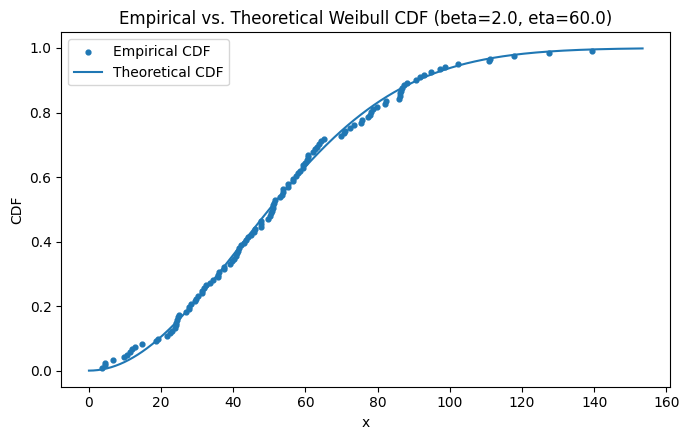

In [ ]:
from scipy.stats import weibull_min

beta_true, eta_true = 2.0, 60.0
rng = np.random.default_rng(7)
n = 120
samples = weibull_min.rvs(beta_true, scale=eta_true, size=n, random_state=rng)

# Empirical CDF
xs = np.sort(samples)
F_emp = np.arange(1, n+1) / (n+1)

# Theoretical CDF
x_plot = np.linspace(0, xs.max()*1.1, 500)
F_the = weibull_cdf(x_plot, beta_true, eta_true)

plt.figure(figsize=(7,4.5))
plt.scatter(xs, F_emp, s=12, label="Empirical CDF")
plt.plot(x_plot, F_the, label="Theoretical CDF")
plt.xlabel("x")
plt.ylabel("CDF")
plt.title(f"Empirical vs. Theoretical Weibull CDF (beta={beta_true}, eta={eta_true})")
plt.legend()
plt.tight_layout()
plt.show()


# 3  Linearization and Parameter Extraction

To extract Weibull parameters from data, we can **linearize** the cumulative form:

$$
F(x) = 1 - e^{-(x/\eta)^\beta}.
$$

Rearranging:

$$
\ln[-\ln(1 - F)] = \beta \ln(x) - \beta \ln(\eta).
$$

Plotting $\ln[-\ln(1 - F)]$ (vertical axis) versus $\ln(x)$ (horizontal axis) should yield a straight line:

- **Slope =** $\beta$ (shape parameter)  
- **Intercept =** $-\beta \ln(\eta)$

This is known as a *Weibull plot* and allows linear regression to determine both parameters.

---

We'll simulate breakdown data to illustrate this approach, using both:
1. **Manual linear regression** on the transformed data, and  
2. **Maximum likelihood fitting** via `scipy.stats.weibull_min.fit`.

The code cells below (a) compute the Weibull-plot transform with a bias-reduced empirical CDF, (b) do linear regression to extract 𝛽, 𝜂, (c) compare with scipy.stats.weibull_min.fit, and (d) add diagnostics (residuals + bootstrap CIs).

[Linearized fit] beta = 9.422, eta = 4.944


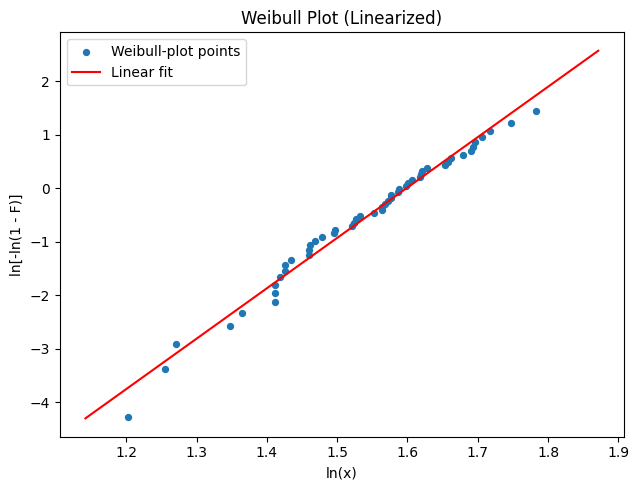

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# If you already created 'data' above, this cell will use it.
# Otherwise, uncomment the next 3 lines to simulate:
# from scipy.stats import weibull_min
# rng = np.random.default_rng(2)
# data = weibull_min.rvs(10.0, scale=50.0, size=50, random_state=rng)

# Sort and empirical CDF using Benard's median ranks: F_i = (i - 0.3)/(n + 0.4)
x_sorted = np.sort(np.asarray(data))
n = len(x_sorted)
i = np.arange(1, n+1)
F_emp = (i - 0.3) / (n + 0.4)

# Weibull plot transform
X = np.log(x_sorted)
Y = np.log(-np.log(1 - F_emp))

# Linear regression on (X, Y)
coef = np.polyfit(X, Y, 1)
beta_lin = coef[0]
eta_lin = np.exp(-coef[1] / beta_lin)

print(f"[Linearized fit] beta = {beta_lin:.3f}, eta = {eta_lin:.3f}")

# Plot: Weibull plot with fitted line
xx = np.linspace(X.min()*0.95, X.max()*1.05, 200)
yy = beta_lin * xx + coef[1]

plt.figure(figsize=(6.5, 5))
plt.scatter(X, Y, s=18, label="Weibull-plot points")
plt.plot(xx, yy, 'r', label="Linear fit")
plt.xlabel("ln(x)")
plt.ylabel("ln[-ln(1 - F)]")
plt.title("Weibull Plot (Linearized)")
plt.legend()
plt.tight_layout()
plt.show()


### Example: Grain Size Distribution

Grain size is a critical microstructural feature in many materials, influencing properties like strength, hardness, and electrical conductivity. Grain size distributions are often found to follow a log-normal distribution. We can use the empirical CDF to visualize experimental grain size data and compare it to a fitted log-normal distribution.

Fitted Log-Normal parameters: s = 0.440, scale = 9.849
Fitted Normal parameters: mu = 10.890, sigma = 5.349
Fitted Weibull parameters: beta = 2.143, eta = 12.329


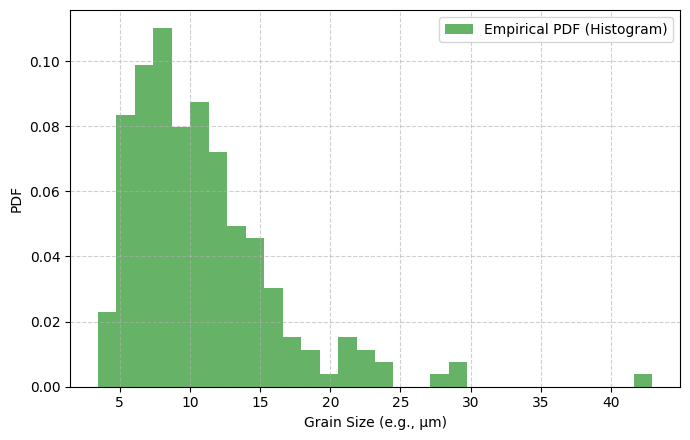

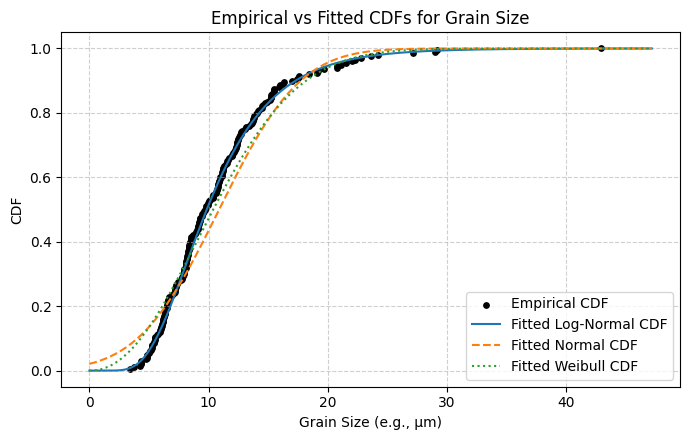

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm, weibull_min

# Simulate grain size data (log-normal distribution)
# Parameters for log-normal: s (shape), loc (location), scale (scale)
# scale is related to the median of the distribution (exp(mean of log(x)))
s_true, scale_true = 0.5, 10.0 # Example parameters
rng = np.random.default_rng(42)
n_grains = 200
grain_sizes = lognorm.rvs(s_true, scale=scale_true, size=n_grains, random_state=rng)

# Sort the data for empirical CDF
grain_sizes_sorted = np.sort(grain_sizes)

# Empirical CDF (simple i/n for visualization)
F_emp_grains = np.arange(1, n_grains + 1) / n_grains

# Fit log-normal distribution to the data using MLE
s_fit_lognorm, loc_fit_lognorm, scale_fit_lognorm = lognorm.fit(grain_sizes, floc=0) # Assuming loc=0 for typical grain size

print(f"Fitted Log-Normal parameters: s = {s_fit_lognorm:.3f}, scale = {scale_fit_lognorm:.3f}")

# Fit Normal distribution to the data using MLE
mu_fit_norm, sigma_fit_norm = norm.fit(grain_sizes)
print(f"Fitted Normal parameters: mu = {mu_fit_norm:.3f}, sigma = {sigma_fit_norm:.3f}")

# Fit Weibull distribution to the data using MLE
beta_fit_weibull, loc_fit_weibull, eta_fit_weibull = weibull_min.fit(grain_sizes, floc=0) # Assuming loc=0 for 2-parameter Weibull
print(f"Fitted Weibull parameters: beta = {beta_fit_weibull:.3f}, eta = {eta_fit_weibull:.3f}")


# Theoretical CDF and PDF for the fitted distributions
x_plot_grains = np.linspace(0, grain_sizes_sorted.max() * 1.1, 300)

F_the_lognorm = lognorm.cdf(x_plot_grains, s_fit_lognorm, loc=loc_fit_lognorm, scale=scale_fit_lognorm)
P_the_lognorm = lognorm.pdf(x_plot_grains, s_fit_lognorm, loc=loc_fit_lognorm, scale=scale_fit_lognorm)

F_the_norm = norm.cdf(x_plot_grains, loc=mu_fit_norm, scale=sigma_fit_norm)
P_the_norm = norm.pdf(x_plot_grains, loc=mu_fit_norm, scale=sigma_fit_norm)

F_the_weibull = weibull_min.cdf(x_plot_grains, beta_fit_weibull, loc=loc_fit_weibull, scale=eta_fit_weibull)


# Plotting PDF
plt.figure(figsize=(7, 4.5))
#plt.plot(x_plot_grains, P_the_lognorm, label="Fitted Log-Normal PDF")
#plt.plot(x_plot_grains, P_the_norm, '--', label="Fitted Normal PDF")
plt.hist(grain_sizes, bins=30, density=True, alpha=0.6, color='g', label="Empirical PDF (Histogram)")
plt.xlabel("Grain Size (e.g., µm)")
plt.ylabel("PDF")
#plt.title("Empirical vs Fitted PDFs for Grain Size")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Plotting CDF
plt.figure(figsize=(7, 4.5))
plt.scatter(grain_sizes_sorted, F_emp_grains, s=15, color='k', label="Empirical CDF")
plt.plot(x_plot_grains, F_the_lognorm, label="Fitted Log-Normal CDF")
plt.plot(x_plot_grains, F_the_norm, '--', label="Fitted Normal CDF")
plt.plot(x_plot_grains, F_the_weibull, ':', label="Fitted Weibull CDF")
plt.xlabel("Grain Size (e.g., µm)")
plt.ylabel("CDF")
plt.title("Empirical vs Fitted CDFs for Grain Size")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Parameter Extraction Methods

The notebook demonstrates two primary methods for extracting the shape ($\beta$) and scale ($\eta$) parameters from Weibull distributed data:

1.  **Linearization and Linear Regression:**
    *   This method is based on transforming the Cumulative Distribution Function (CDF) of the Weibull distribution into a linear form:
        $$ \ln[-\ln(1 - F)] = \beta \ln(x) - \beta \ln(\eta) $$
    *   By plotting $\ln[-\ln(1 - F)]$ against $\ln(x)$, you get a straight line.
    *   The slope of this line gives the shape parameter $\beta$.
    *   The intercept of the line is equal to $-\beta \ln(\eta)$, from which you can calculate the scale parameter $\eta$.
    *   This method is visually intuitive and easy to implement.

2.  **Maximum Likelihood Estimation (MLE):**
    *   MLE is a statistical method that finds the parameters ($\beta$ and $\eta$) that maximize the likelihood of observing the given dataset.
    *   It's generally considered a more statistically robust method than linearization, especially for smaller sample sizes.
    *   The `scipy.stats.weibull_min.fit` function in the notebook uses MLE to estimate the parameters. It finds the values of $\beta$ and $\eta$ that make the observed data most probable under the Weibull distribution assumption.

### Empirical CDF using Benard's Median Ranks

The **empirical CDF (ECDF)** is a step function that estimates the CDF from observed data. For a sorted dataset $x_1 \le x_2 \le \dots \le x_n$, a simple ECDF assigns a probability of $i/n$ to $x_i$, where $i$ is the rank and $n$ is the total number of data points.

However, when transforming the data for a Weibull plot using $\ln[-\ln(1-F)]$, if $F=1$, the expression becomes undefined. Using the simple $i/n$ can result in $F=1$ for the largest observation ($i=n$).

**Benard's median ranks** provide a bias-reduced estimate for the empirical CDF, particularly useful for linearization methods like the Weibull plot. The formula used is:

$$ F_i = \frac{i - 0.3}{n + 0.4} $$

Where:
*   $i$ is the rank of the sorted data point (from 1 to $n$).
*   $n$ is the total number of data points.

This formula ensures that the estimated probability $F_i$ is never exactly 0 or 1, preventing issues with the $\ln[-\ln(1-F)]$ transformation and providing a better approximation of the true underlying CDF, especially for plotting and linear regression purposes.

[MLE (scipy)]   beta = 9.101, eta = 4.950


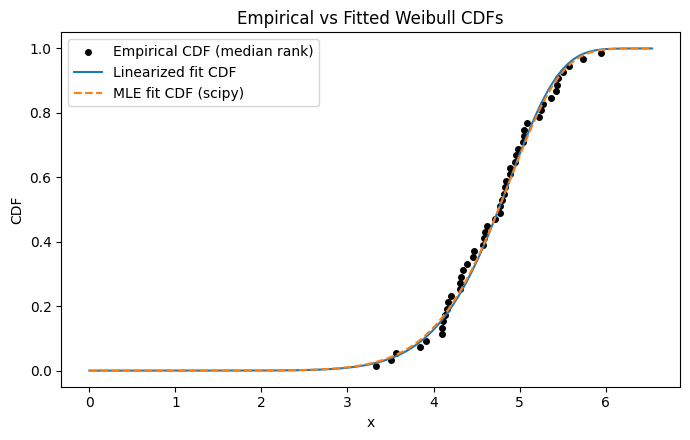

In [ ]:
from scipy.stats import weibull_min

# Constrain loc=0 for standard 2-parameter Weibull
beta_mle, loc_mle, eta_mle = weibull_min.fit(x_sorted, floc=0.0)
print(f"[MLE (scipy)]   beta = {beta_mle:.3f}, eta = {eta_mle:.3f}")

# Overlay empirical CDF with fitted CDFs
x_plot = np.linspace(0, x_sorted.max()*1.1, 400)
F_lin = 1 - np.exp(-(x_plot/eta_lin)**beta_lin)
F_mle = weibull_min.cdf(x_plot, beta_mle, loc=0.0, scale=eta_mle)

plt.figure(figsize=(7, 4.5))
plt.scatter(x_sorted, F_emp, s=16, color="k", label="Empirical CDF (median rank)")
plt.plot(x_plot, F_lin, label="Linearized fit CDF")
plt.plot(x_plot, F_mle, '--', label="MLE fit CDF (scipy)")
plt.xlabel("x")
plt.ylabel("CDF")
plt.title("Empirical vs Fitted Weibull CDFs")
plt.legend()
plt.tight_layout()
plt.show()


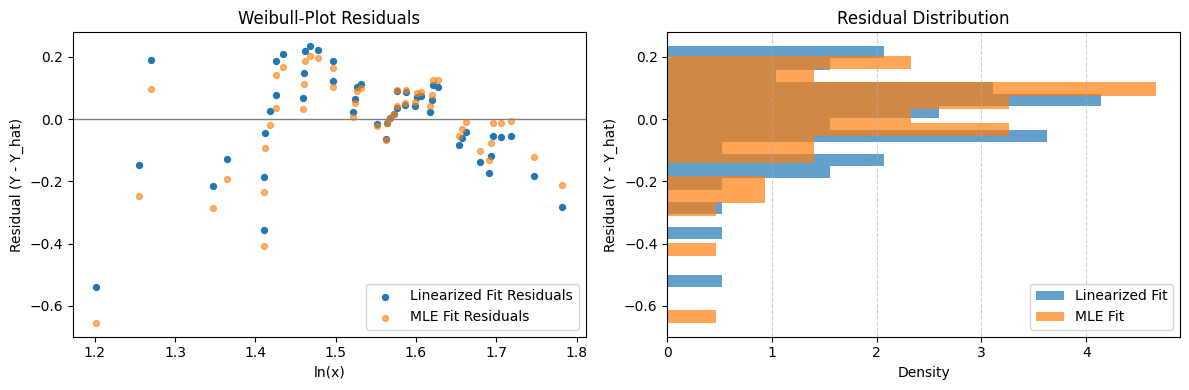

In [ ]:
# Predicted Y from linear fit at observed X
Y_hat_lin = beta_lin * X + coef[1]
resid_lin = Y - Y_hat_lin

# Predicted Y from MLE fit at observed X
# Need to transform the MLE fit CDF back to the linearized Y space
F_mle_at_x = weibull_min.cdf(x_sorted, beta_mle, loc=0.0, scale=eta_mle)
Y_hat_mle = np.log(-np.log(1 - F_mle_at_x))
resid_mle = Y - Y_hat_mle


fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # Create a figure with two subplots

# Left subplot: Residuals scatter plot
axes[0].axhline(0, color='gray', linewidth=1)
axes[0].scatter(X, resid_lin, s=18, label="Linearized Fit Residuals")
axes[0].scatter(X, resid_mle, s=18, alpha=0.6, label="MLE Fit Residuals")
axes[0].set_xlabel("ln(x)")
axes[0].set_ylabel("Residual (Y - Y_hat)")
axes[0].set_title("Weibull-Plot Residuals")
axes[0].legend()

# Right subplot: Residuals histograms
axes[1].hist(resid_lin, bins=20, orientation='horizontal', alpha=0.7, label="Linearized Fit", density=True)
axes[1].hist(resid_mle, bins=20, orientation='horizontal', alpha=0.7, label="MLE Fit", density=True)
axes[1].set_xlabel("Density") # Label for counts on x-axis (density=True normalizes to area=1)
axes[1].set_ylabel("Residual (Y - Y_hat)") # Label for residual values on y-axis
axes[1].set_title("Residual Distribution")
axes[1].legend()
axes[1].grid(axis='x', linestyle='--', alpha=0.6) # Add grid for clarity

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

In [ ]:
# Bootstrap (resample x with replacement, recompute median-rank fit)
rng = np.random.default_rng(123)
B = 1000
betas = np.empty(B)
etas = np.empty(B)

for b in range(B):
    xb = rng.choice(x_sorted, size=n, replace=True)
    xb = np.sort(xb)
    Fb = (i - 0.3) / (n + 0.4)
    Xb = np.log(xb)
    Yb = np.log(-np.log(1 - Fb))
    c = np.polyfit(Xb, Yb, 1)
    betas[b] = c[0]
    etas[b]  = np.exp(-c[1] / c[0])

beta_ci = np.percentile(betas, [2.5, 50, 97.5])
eta_ci  = np.percentile(etas,  [2.5, 50, 97.5])

print(f"[Bootstrap 95% CI] beta: {beta_ci[0]:.3f} — {beta_ci[2]:.3f} (median {beta_ci[1]:.3f})")
print(f"[Bootstrap 95% CI] eta : {eta_ci[0]:.3f} — {eta_ci[2]:.3f} (median {eta_ci[1]:.3f})")


[Bootstrap 95% CI] beta: 7.890 — 11.594 (median 9.447)
[Bootstrap 95% CI] eta : 4.791 — 5.094 (median 4.935)


# Dielectric Breakdown Simulation ($V_{bd}$)


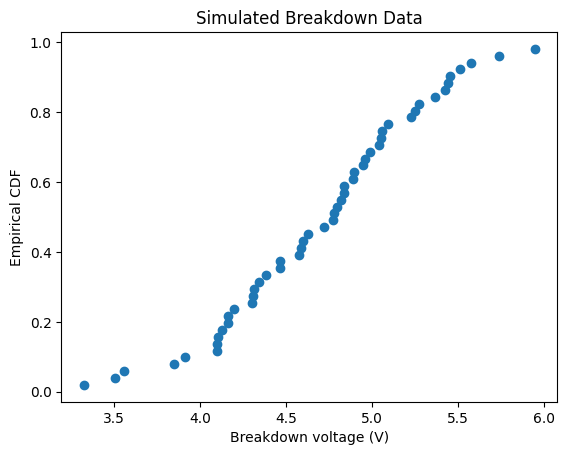

In [ ]:
# Placeholder: simulate breakdown data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import weibull_min

rng = np.random.default_rng(11)
beta_true, eta_true = 10.0, 5.0
data = weibull_min.rvs(beta_true, scale=eta_true, size=50, random_state=rng)

# Sort and compute empirical CDF
x_sorted = np.sort(data)
F_emp = np.arange(1, len(x_sorted)+1) / (len(x_sorted)+1)

plt.scatter(x_sorted, F_emp)
plt.xlabel("Breakdown voltage (V)")
plt.ylabel("Empirical CDF")
plt.title("Simulated Breakdown Data")
plt.show()


Now compute the **Weibull plot coordinates**:

$$
Y = \ln[-\ln(1 - F)] , \quad X = \ln(x).
$$

Perform a simple linear regression to extract slope ($\beta$) and intercept.


In [ ]:
# Placeholder: linear regression
Y = np.log(-np.log(1 - F_emp))
X = np.log(x_sorted)
coeffs = np.polyfit(X, Y, 1)
beta_fit = coeffs[0]
eta_fit = np.exp(-coeffs[1] / beta_fit)

print(f"Linear fit results: beta = {beta_fit:.2f}, eta = {eta_fit:.2f}")


Linear fit results: beta = 9.06, eta = 4.95


Finally, compare with `scipy.stats.weibull_min.fit` results and plot both fits to visualize the CDF agreement.


MLE fit: beta = 9.10, eta = 4.95


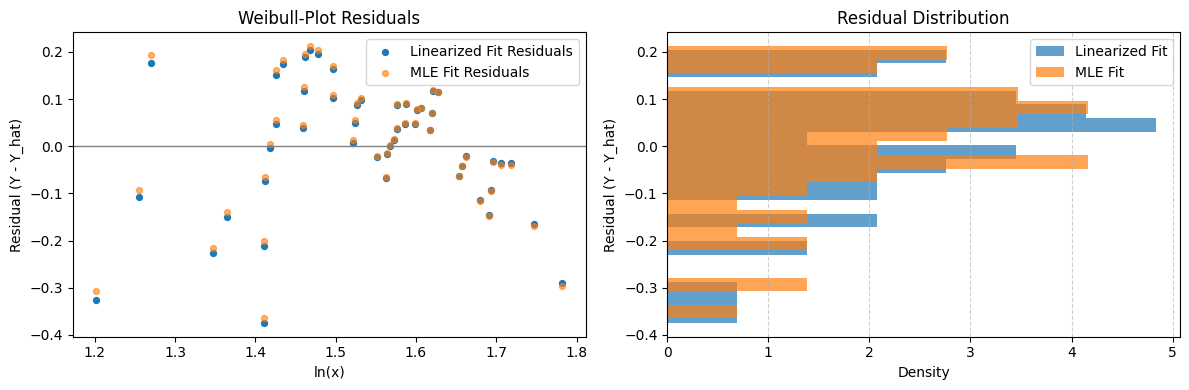

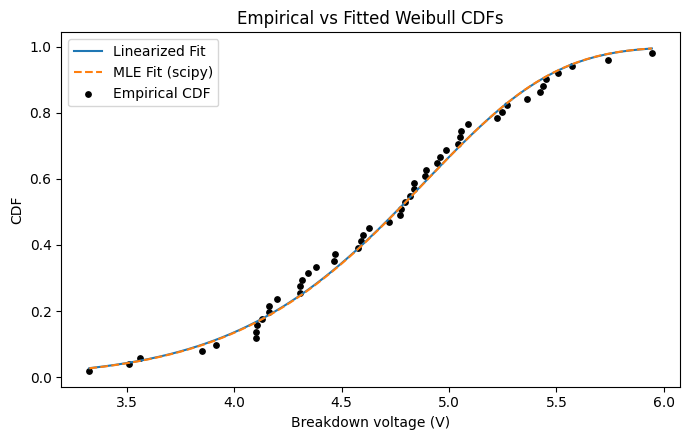

In [ ]:
# Placeholder: scipy fit comparison
from scipy.stats import weibull_min

beta_mle, loc_mle, eta_mle = weibull_min.fit(data, floc=0)
print(f"MLE fit: beta = {beta_mle:.2f}, eta = {eta_mle:.2f}")

x_plot = np.linspace(min(data), max(data), 200)
F_lin = 1 - np.exp(-(x_plot/eta_fit)**beta_fit)
F_mle = weibull_min.cdf(x_plot, beta_mle, scale=eta_mle)

# Calculate residuals based on the empirical CDF used in this section (i/(n+1))
n_otiau = len(x_sorted)
i_otiau = np.arange(1, n_otiau + 1)
F_emp_otiau = i_otiau / (n_otiau + 1)
Y_otiau = np.log(-np.log(1 - F_emp_otiau))
X_otiau = np.log(x_sorted)

# Predicted Y from linear fit at observed X
Y_hat_lin_otiau = beta_fit * X_otiau + coeffs[1]
resid_lin_otiau = Y_otiau - Y_hat_lin_otiau

# Predicted Y from MLE fit at observed X
F_mle_at_x_otiau = weibull_min.cdf(x_sorted, beta_mle, loc=0.0, scale=eta_mle)
Y_hat_mle_otiau = np.log(-np.log(1 - F_mle_at_x_otiau))
resid_mle_otiau = Y_otiau - Y_hat_mle_otiau


fig, axes = plt.subplots(1, 2, figsize=(12, 4)) # Create a figure with two subplots

# Left subplot: Residuals scatter plot
axes[0].axhline(0, color='gray', linewidth=1)
axes[0].scatter(X_otiau, resid_lin_otiau, s=18, label="Linearized Fit Residuals")
axes[0].scatter(X_otiau, resid_mle_otiau, s=18, alpha=0.6, label="MLE Fit Residuals")
axes[0].set_xlabel("ln(x)")
axes[0].set_ylabel("Residual (Y - Y_hat)")
axes[0].set_title("Weibull-Plot Residuals")
axes[0].legend()

# Right subplot: Residuals histograms
axes[1].hist(resid_lin_otiau, bins=20, orientation='horizontal', alpha=0.7, label="Linearized Fit", density=True)
axes[1].hist(resid_mle_otiau, bins=20, orientation='horizontal', alpha=0.7, label="MLE Fit", density=True)
axes[1].set_xlabel("Density") # Label for counts on x-axis (density=True normalizes to area=1)
axes[1].set_ylabel("Residual (Y - Y_hat)") # Label for residual values on y-axis
axes[1].set_title("Residual Distribution")
axes[1].legend()
axes[1].grid(axis='x', linestyle='--', alpha=0.6) # Add grid for clarity

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

# Keep the original CDF plot as well for comparison
plt.figure(figsize=(7, 4.5))
plt.plot(x_plot, F_lin, label="Linearized Fit")
plt.plot(x_plot, F_mle, '--', label="MLE Fit (scipy)")
plt.scatter(x_sorted, F_emp_otiau, color='k', s=15, label="Empirical CDF")
plt.xlabel("Breakdown voltage (V)")
plt.ylabel("CDF")
plt.legend()
plt.title("Empirical vs Fitted Weibull CDFs")
plt.tight_layout()
plt.show()

## 5 · Key Distributions in Hypothesis Testing

Hypothesis testing relies on comparing an observed statistic to a reference distribution that represents the **null hypothesis**.\
Below we review four foundational distributions—Normal, Student’s t, Chi-square (χ²), and F—along with examples from materials science.

---

### 5.1 Normal Distribution

**PDF**

$$
f(x; \mu, \sigma) = \frac{1}{\sqrt{2\pi}\sigma}
e^{-\frac{(x - \mu)^2}{2\sigma^2}}.
$$

**Meaning**

The Normal distribution describes quantities resulting from many small, independent effects.\
It is central to the **Central Limit Theorem**, which explains why measurement errors often appear Gaussian.

**Materials Example**

In X-ray diffraction or Raman spectroscopy, repeated measurements of a peak position fluctuate symmetrically around a mean value due to instrument noise and counting statistics.\
Assuming Gaussian noise allows confidence intervals on lattice parameters or phonon energies.

---

### 5.2 Student’s t Distribution

**Context**

When estimating the mean of a normally distributed population but the variance is **unknown** and must be estimated from limited data, the uncertainty in the estimate increases.\
The t distribution accounts for this extra uncertainty.

**PDF**

$$
f(x;\nu) =
\frac{\Gamma\left(\frac{\nu + 1}{2}\right)}
{\sqrt{\nu \pi}\,\Gamma\left(\frac{\nu}{2}\right)}
\left(1 + \frac{x^2}{\nu}\right)^{-\frac{\nu + 1}{2}},
$$

where $\nu$ is the **degrees of freedom**.

**Materials Example**

When comparing the average grain size from two small batches of thin-film samples (n ≈ 5 each), the sample variance is uncertain.\
A t-test determines whether the apparent difference in means is statistically significant.

---

### 5.3 Chi-Square (χ²) Distribution

**Definition**

The sum of squared standard normal variables follows a χ² distribution:

$$
\chi^2 = \sum_{i=1}^{\nu} Z_i^2, \quad Z_i \sim \mathcal{N}(0,1).
$$

**Usage**

- Testing **variance** hypotheses.  
- **Goodness-of-fit** for models: comparing observed vs. expected frequencies.

**Materials Example**

In XRD pattern fitting, the residuals between measured and simulated intensities are squared and summed.\
The reduced χ² statistic indicates whether the fit residuals are consistent with experimental uncertainty.

---

### 5.4 F Distribution

**Definition**

The ratio of two scaled χ² variables defines the F distribution:

$$
F = \frac{(S_1^2 / \nu_1)}{(S_2^2 / \nu_2)}.
$$

**Usage**

Used to compare **variances** or evaluate whether a more complex model significantly improves the fit.

**Materials Example**

When fitting photoluminescence spectra, one may test whether adding a second Gaussian peak improves the fit beyond noise.\
An F-test compares the variance reduction achieved by the two-peak model against the variance expected from random noise.

---

### Conceptual Connections

| Distribution | Derived From | Typical Role | Materials Analogy |
|---------------|--------------|---------------|-------------------|
| Normal | Many small independent effects | Baseline model for noise | Instrumental fluctuations |
| t | Normal + estimated variance | Small-sample mean tests | Mean grain size comparison |
| χ² | Sum of squared Normal terms | Variance/goodness-of-fit | XRD or Raman residuals |
| F | Ratio of χ² terms | Model comparison | One- vs two-peak spectral fits |

Together these distributions form the core statistical toolkit for determining whether observed differences are **statistically significant** or just **measurement variability**.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, chi2, f


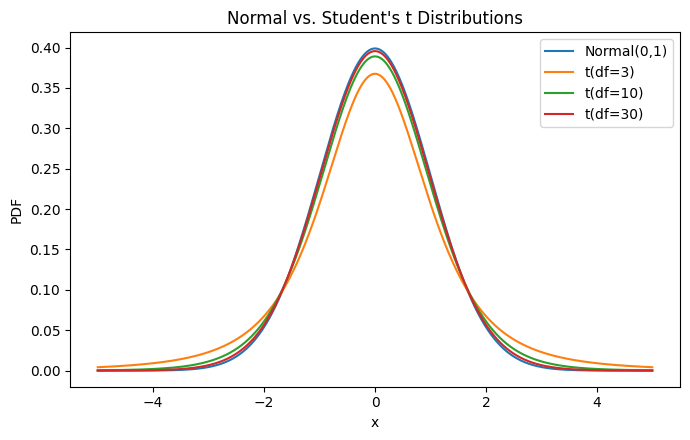

Notes:
- The t distribution has heavier tails for small df (greater uncertainty in σ).
- As df → ∞, t converges to Normal.
- Hypothesis testing: t is used for small-sample mean tests when σ is unknown.


In [ ]:
# Parameters
mu, sigma = 0.0, 1.0  # standard normal for reference
dfs = [3, 10, 30]     # t degrees of freedom to compare

# Domain
x = np.linspace(-5, 5, 1000)

plt.figure(figsize=(7, 4.5))
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), label="Normal(0,1)")
for nu in dfs:
    plt.plot(x, t.pdf(x, df=nu), label=f"t(df={nu})")
plt.xlabel("x")
plt.ylabel("PDF")
plt.title("Normal vs. Student's t Distributions")
plt.legend()
plt.tight_layout()
plt.show()

# Short textual guide (printed)
print(
    "Notes:\n"
    "- The t distribution has heavier tails for small df (greater uncertainty in σ).\n"
    "- As df → ∞, t converges to Normal.\n"
    "- Hypothesis testing: t is used for small-sample mean tests when σ is unknown."
)


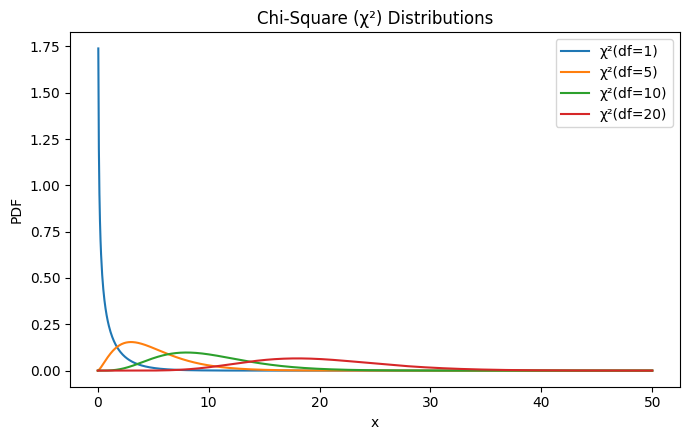

Notes:
- χ² arises as a sum of squares of standard normal variables.
- Typical roles: variance tests; goodness-of-fit; sums of squared residuals.
- In model fitting, reduced χ² near 1 indicates residuals match the assumed noise level.


In [ ]:
# Degrees of freedom to visualize
dfs = [1, 5, 10, 20]
x = np.linspace(0, 50, 1000)

plt.figure(figsize=(7, 4.5))
for nu in dfs:
    plt.plot(x, chi2.pdf(x, df=nu), label=f"χ²(df={nu})")
plt.xlabel("x")
plt.ylabel("PDF")
plt.title("Chi-Square (χ²) Distributions")
plt.legend()
plt.tight_layout()
plt.show()

print(
    "Notes:\n"
    "- χ² arises as a sum of squares of standard normal variables.\n"
    "- Typical roles: variance tests; goodness-of-fit; sums of squared residuals.\n"
    "- In model fitting, reduced χ² near 1 indicates residuals match the assumed noise level."
)


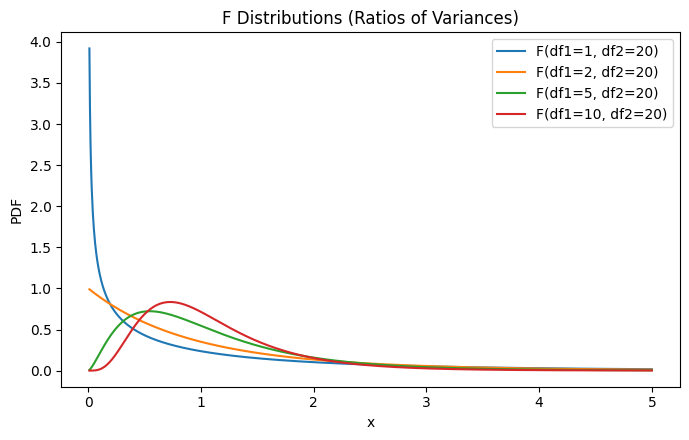

Notes:
- F is the ratio of two scaled χ² variables (often ‘variance of model A’ / ‘variance of model B’).
- Used for model comparison: does adding parameters significantly reduce residual variance?
- Materials example: one- vs two-Gaussian fit for a spectrum peak set.


In [ ]:
pairs = [(1, 20), (2, 20), (5, 20), (10, 20)]
x = np.linspace(0.01, 5, 1000)

plt.figure(figsize=(7, 4.5))
for d1, d2 in pairs:
    plt.plot(x, f.pdf(x, dfn=d1, dfd=d2), label=f"F(df1={d1}, df2={d2})")
plt.xlabel("x")
plt.ylabel("PDF")
plt.title("F Distributions (Ratios of Variances)")
plt.legend()
plt.tight_layout()
plt.show()

print(
    "Notes:\n"
    "- F is the ratio of two scaled χ² variables (often ‘variance of model A’ / ‘variance of model B’).\n"
    "- Used for model comparison: does adding parameters significantly reduce residual variance?\n"
    "- Materials example: one- vs two-Gaussian fit for a spectrum peak set."
)


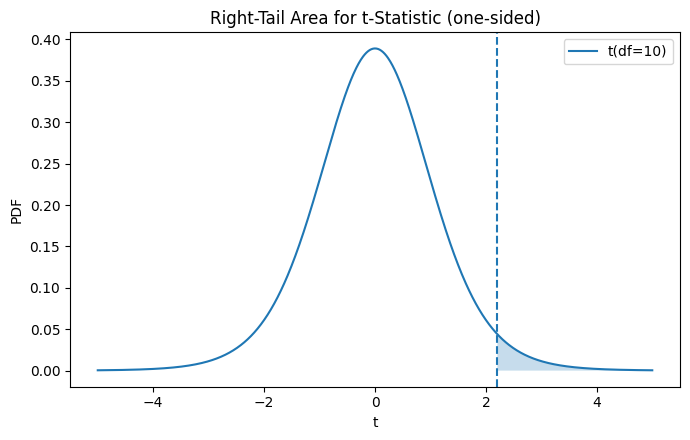

t-observed = 2.20, one-sided p = 0.0262, two-sided p = 0.0524


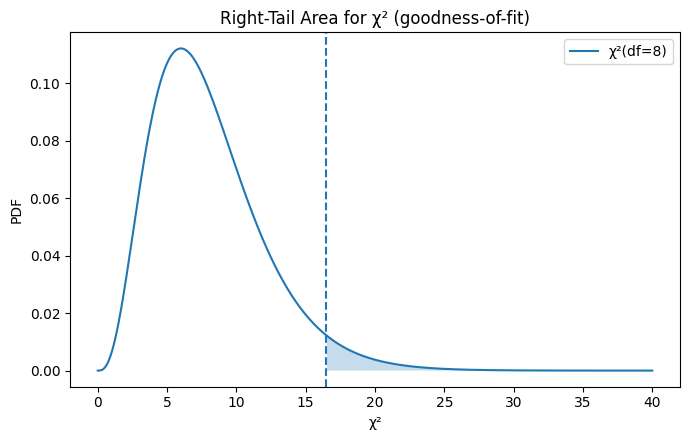

χ²-observed = 16.50, right-tail p = 0.0358


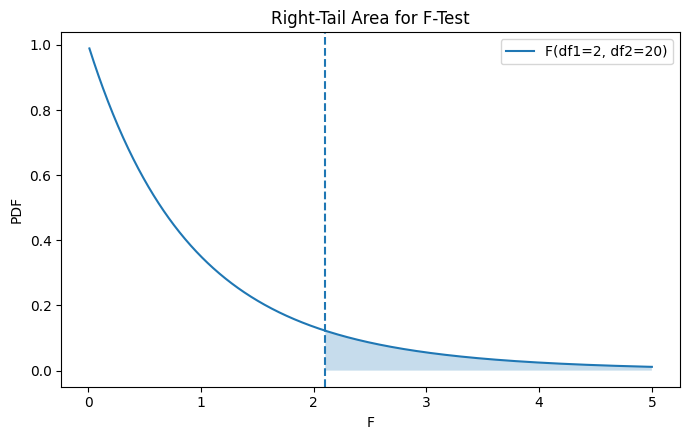

F-observed = 2.10, right-tail p = 0.1486


In [ ]:
def shade_right_tail(ax, x, pdf_vals, x0):
    """Shade the right-tail area x >= x0 under the given curve."""
    mask = x >= x0
    ax.fill_between(x[mask], pdf_vals[mask], 0.0, alpha=0.25)
    ax.axvline(x0, linestyle="--")

# Example 1: t-test right-tail p-value
nu = 10
x = np.linspace(-5, 5, 1000)
pdf_t = t.pdf(x, df=nu)
t_obs = 2.2  # observed test statistic (example)

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(x, pdf_t, label=f"t(df={nu})")
shade_right_tail(ax, x, pdf_t, t_obs)
ax.set_xlabel("t")
ax.set_ylabel("PDF")
ax.set_title("Right-Tail Area for t-Statistic (one-sided)")
ax.legend()
plt.tight_layout()
plt.show()

p_one_sided = t.sf(t_obs, df=nu)     # survival function (right-tail)
p_two_sided = 2 * min(t.cdf(t_obs, nu), t.sf(t_obs, nu))
print(f"t-observed = {t_obs:.2f}, one-sided p = {p_one_sided:.4f}, two-sided p = {p_two_sided:.4f}")

# Example 2: χ² goodness-of-fit right-tail p-value
nu = 8
x = np.linspace(0, 40, 1000)
pdf_chi2 = chi2.pdf(x, df=nu)
chi2_obs = 16.5

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(x, pdf_chi2, label=f"χ²(df={nu})")
shade_right_tail(ax, x, pdf_chi2, chi2_obs)
ax.set_xlabel("χ²")
ax.set_ylabel("PDF")
ax.set_title("Right-Tail Area for χ² (goodness-of-fit)")
ax.legend()
plt.tight_layout()
plt.show()

p_chi2 = chi2.sf(chi2_obs, df=nu)
print(f"χ²-observed = {chi2_obs:.2f}, right-tail p = {p_chi2:.4f}")

# Example 3: F-test for model comparison (variance ratio)
df1, df2 = 2, 20
x = np.linspace(0.01, 5, 1000)
pdf_f = f.pdf(x, dfn=df1, dfd=df2)
F_obs = 2.1

fig, ax = plt.subplots(figsize=(7, 4.5))
ax.plot(x, pdf_f, label=f"F(df1={df1}, df2={df2})")
shade_right_tail(ax, x, pdf_f, F_obs)
ax.set_xlabel("F")
ax.set_ylabel("PDF")
ax.set_title("Right-Tail Area for F-Test")
ax.legend()
plt.tight_layout()
plt.show()

p_f = f.sf(F_obs, dfn=df1, dfd=df2)
print(f"F-observed = {F_obs:.2f}, right-tail p = {p_f:.4f}")


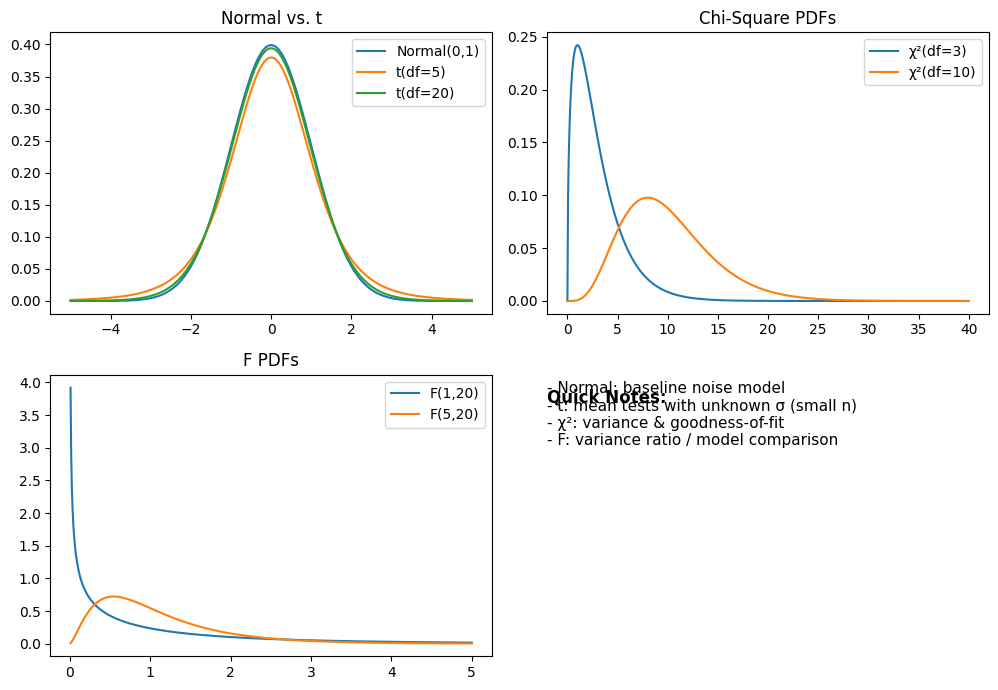

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Normal vs. t
x = np.linspace(-5, 5, 600)
axes[0,0].plot(x, norm.pdf(x), label="Normal(0,1)")
axes[0,0].plot(x, t.pdf(x, df=5), label="t(df=5)")
axes[0,0].plot(x, t.pdf(x, df=20), label="t(df=20)")
axes[0,0].set_title("Normal vs. t")
axes[0,0].legend()

# χ²
x = np.linspace(0, 40, 600)
axes[0,1].plot(x, chi2.pdf(x, df=3), label="χ²(df=3)")
axes[0,1].plot(x, chi2.pdf(x, df=10), label="χ²(df=10)")
axes[0,1].set_title("Chi-Square PDFs")
axes[0,1].legend()

# F
x = np.linspace(0.01, 5, 600)
axes[1,0].plot(x, f.pdf(x, dfn=1, dfd=20), label="F(1,20)")
axes[1,0].plot(x, f.pdf(x, dfn=5, dfd=20), label="F(5,20)")
axes[1,0].set_title("F PDFs")
axes[1,0].legend()

# Legend panel (or quick notes)
axes[1,1].axis("off")
axes[1,1].text(
    0.0, 0.9, "Quick Notes:", fontsize=12, fontweight="bold"
)
axes[1,1].text(
    0.0, 0.75,
    "- Normal: baseline noise model\n"
    "- t: mean tests with unknown σ (small n)\n"
    "- χ²: variance & goodness-of-fit\n"
    "- F: variance ratio / model comparison",
    fontsize=11
)

plt.tight_layout()
plt.show()
